In [1]:
!pip install tqdm opencv-python scikit-image seaborn matplotlib pandas scikit-learn tensorflow


In [2]:
# import system libs
import os
import time
import random
import pathlib

import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-04-20 06:06:25.939626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745129186.175853      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745129186.248991      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [4]:
model_dir = '/kaggle/working/unet_models'
os.makedirs(model_dir, exist_ok=True)  # Create directory if not exists
model_path = os.path.join(model_dir, 'unet_best.h5')


In [5]:
def create_df(data_dir):
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    images_paths = [p.replace('_mask', '') for p in masks_paths]
    return pd.DataFrame({'images_paths': images_paths, 'masks_paths': masks_paths})

def split_df(df):
    train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42)
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)
    return train_df, valid_df, test_df

In [6]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40
    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths',
                     class_mode=None, color_mode='rgb', target_size=img_size,
                     batch_size=batch_size, seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths',
                     class_mode=None, color_mode='grayscale', target_size=img_size,
                     batch_size=batch_size, seed=1)

    for (img, msk) in zip(image_gen, mask_gen):
        img = img / 255.0
        msk = msk / 255.0
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        yield (img, msk)


In [7]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(64, (3, 3), padding="same")(inputs)
    c1 = Activation("relu")(c1)
    c1 = Conv2D(64, (3, 3), padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), padding="same")(p1)
    c2 = Activation("relu")(c2)
    c2 = Conv2D(128, (3, 3), padding="same")(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), padding="same")(p2)
    c3 = Activation("relu")(c3)
    c3 = Conv2D(256, (3, 3), padding="same")(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), padding="same")(p3)
    c4 = Activation("relu")(c4)
    c4 = Conv2D(512, (3, 3), padding="same")(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), padding="same")(p4)
    c5 = Activation("relu")(c5)
    c5 = Conv2D(1024, (3, 3), padding="same")(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    # Decoder
    u6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5), c4])
    c6 = Conv2D(512, (3, 3), padding="same")(u6)
    c6 = Activation("relu")(c6)
    c6 = Conv2D(512, (3, 3), padding="same")(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)

    u7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6), c3])
    c7 = Conv2D(256, (3, 3), padding="same")(u7)
    c7 = Activation("relu")(c7)
    c7 = Conv2D(256, (3, 3), padding="same")(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)

    u8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7), c2])
    c8 = Conv2D(128, (3, 3), padding="same")(u8)
    c8 = Activation("relu")(c8)
    c8 = Conv2D(128, (3, 3), padding="same")(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)

    u9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8), c1])
    c9 = Conv2D(64, (3, 3), padding="same")(u9)
    c9 = Activation("relu")(c9)
    c9 = Conv2D(64, (3, 3), padding="same")(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)
    return Model(inputs=[inputs], outputs=[outputs])

In [8]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [9]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(masks[i])
        plt.imshow(img)
        plt.imshow(mask, alpha=0.4)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']
    epochs = list(range(1, len(tr_acc)+1))
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')
    plt.subplot(2,2,1)
    plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(2,2,2)
    plt.plot(epochs, tr_iou, 'r', label='Train IoU')
    plt.plot(epochs, val_iou, 'g', label='Val IoU')
    plt.title('IoU')
    plt.legend()
    plt.subplot(2,2,3)
    plt.plot(epochs, tr_dice, 'r', label='Train Dice')
    plt.plot(epochs, val_dice, 'g', label='Val Dice')
    plt.title('Dice')
    plt.legend()
    plt.subplot(2,2,4)
    plt.plot(epochs, tr_loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'g', label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

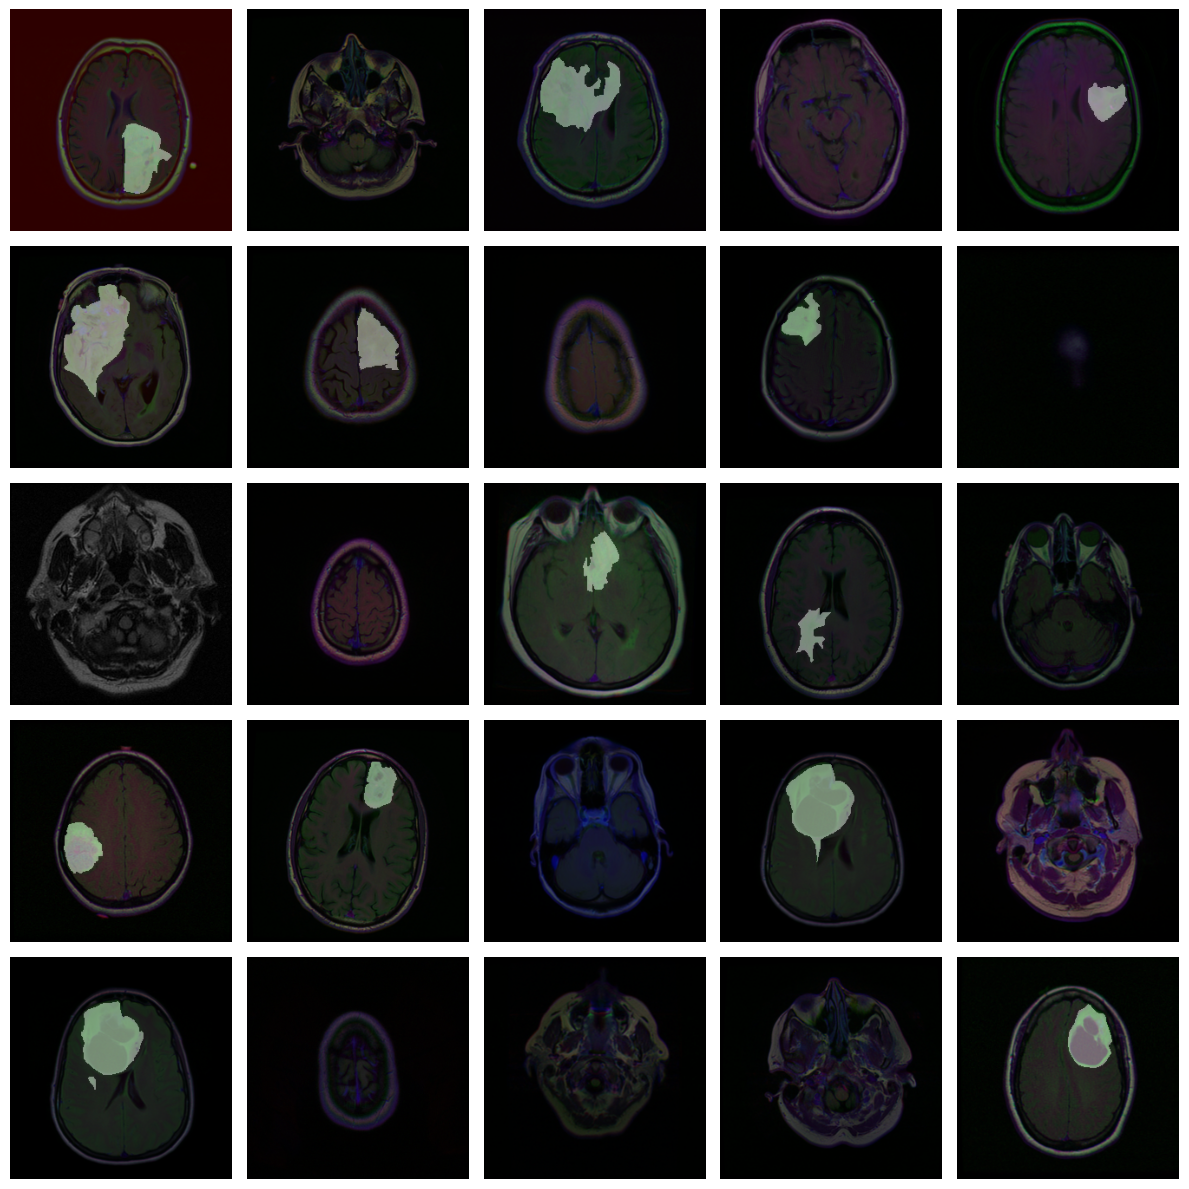

In [11]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

tr_aug_dict = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [12]:
model = unet()
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss=dice_loss,
              metrics=['accuracy', iou_coef, dice_coef])
model.summary()

I0000 00:00:1745129233.994716      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745129233.995535      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Kaggle paths
model_dir = '/kaggle/working/unet_models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'unet_best.keras')  # Change .h5 to .keras

# Callbacks setup
callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# Model training (unchanged)
history = model.fit(
    train_gen,
    steps_per_epoch=int(len(train_df)/40),
    epochs=120,
    validation_data=valid_gen,
    validation_steps=int(len(valid_df)/40),
    callbacks=callbacks
)


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120


I0000 00:00:1745129269.597446     103 service.cc:148] XLA service 0x7a8e88002ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745129269.598674     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745129269.598695     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745129270.595314     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-20 06:07:59.628701: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[40,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8580 - dice_coef: 0.0778 - iou_coef: 0.0410 - loss: -0.0778Found 393 validated image filenames.
Found 393 validated image filenames.


2025-04-20 06:13:51.604273: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[40,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-20 06:13:51.690747: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.086583379s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[40,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat


Epoch 1: val_dice_coef improved from -inf to 0.02111, saving model to /kaggle/working/unet_models/unet_best.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.8589 - dice_coef: 0.0782 - iou_coef: 0.0413 - loss: -0.0782 - val_accuracy: 0.9899 - val_dice_coef: 0.0211 - val_iou_coef: 0.0108 - val_loss: -0.0211
Epoch 2/120


E0000 00:00:1745129669.112243     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745129669.370004     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745129685.727623     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745129686.075889     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745129702.617850     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9802 - dice_coef: 0.1977 - iou_coef: 0.1113 - loss: -0.1981

E0000 00:00:1745129975.014216     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745129975.305822     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-20 06:19:39.917367: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[33,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a w


Epoch 2: val_dice_coef improved from 0.02111 to 0.04066, saving model to /kaggle/working/unet_models/unet_best.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.9803 - dice_coef: 0.1982 - iou_coef: 0.1117 - loss: -0.1986 - val_accuracy: 0.9897 - val_dice_coef: 0.0407 - val_iou_coef: 0.0210 - val_loss: -0.0405
Epoch 3/120
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9913 - dice_coef: 0.3905 - iou_coef: 0.2475 - loss: -0.3906
Epoch 3: val_dice_coef improved from 0.04066 to 0.07595, saving model to /kaggle/working/unet_models/unet_best.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9913 - dice_coef: 0.3913 - iou_coef: 0.2482 - loss: -0.3914 - val_accuracy: 0.9424 - val_dice_coef: 0.0759 - val_iou_coef: 0.0400 - val_loss: -0.0766
Epoch 4/120
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9932 - dice_coef: 0.5900 - iou_coef: 0.4233 - loss: -0.5892
Epoch 4: val_dice_coef improved from 0.07595 to 0.13780, saving model to /kaggle/working/unet_models/unet_bes

In [14]:
final_model_path = os.path.join(model_dir, 'unet_final.keras')
model.save(final_model_path)
model.save('unet_final.keras')


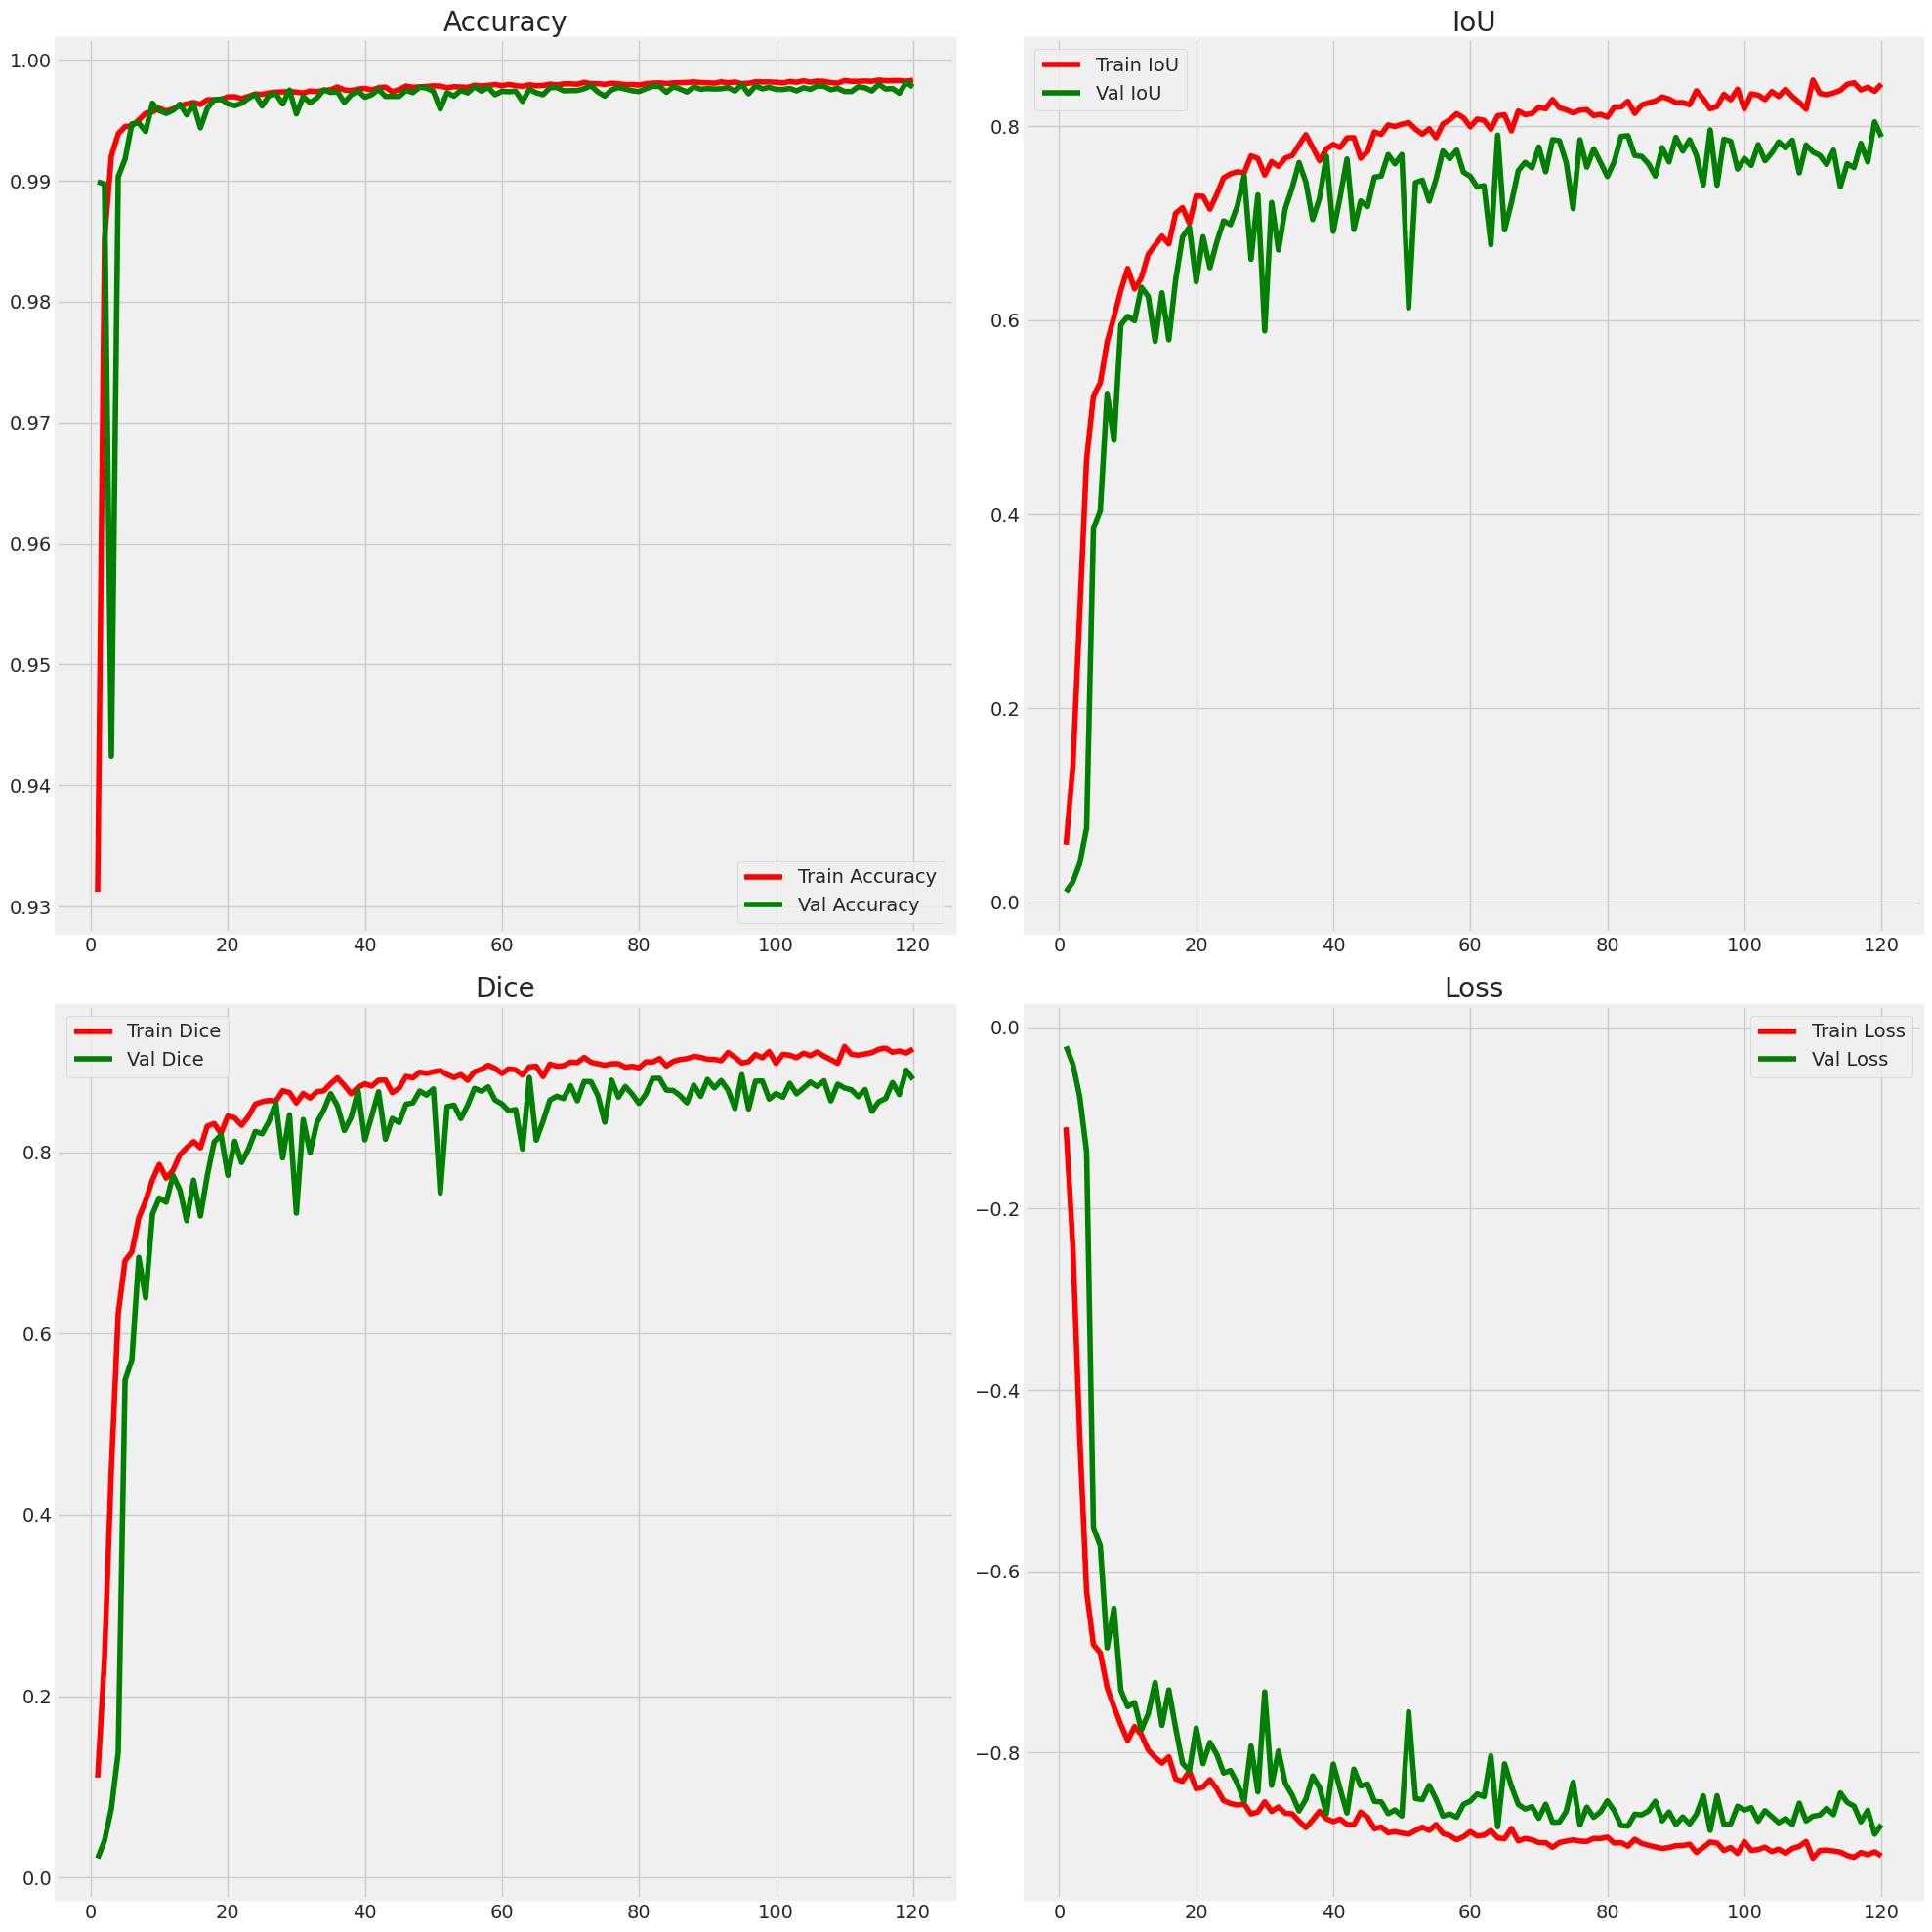

In [15]:
plot_training(history)

In [16]:
ts_length = len(test_df)
test_batch_size = max([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80])
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])


131/131 ━━━━━━━━━━━━━━━━━━━━ 131s 999ms/step - accuracy: 0.9984 - dice_coef: 0.9165 - iou_coef: 0.8473 - loss: -0.9164
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 857ms/step - accuracy: 0.9978 - dice_coef: 0.8799 - iou_coef: 0.7880 - loss: -0.8803
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 858ms/step - accuracy: 0.9975 - dice_coef: 0.8810 - iou_coef: 0.7899 - loss: -0.8811
Train Loss:  -0.915980339050293
Train Accuracy:  0.9983673691749573
Train IoU:  0.8467898368835449
Train Dice:  0.9161248207092285
--------------------
Valid Loss:  -0.8807896971702576
Valid Accuracy:  0.9978232383728027
Valid IoU:  0.7890304923057556
Valid Dice:  0.880466878414154
--------------------
Test Loss:  -0.8806487321853638
Test Accuracy:  0.9975202679634094
Test IoU:  0.7892816066741943
Test Dice:  0.8806772828102112


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


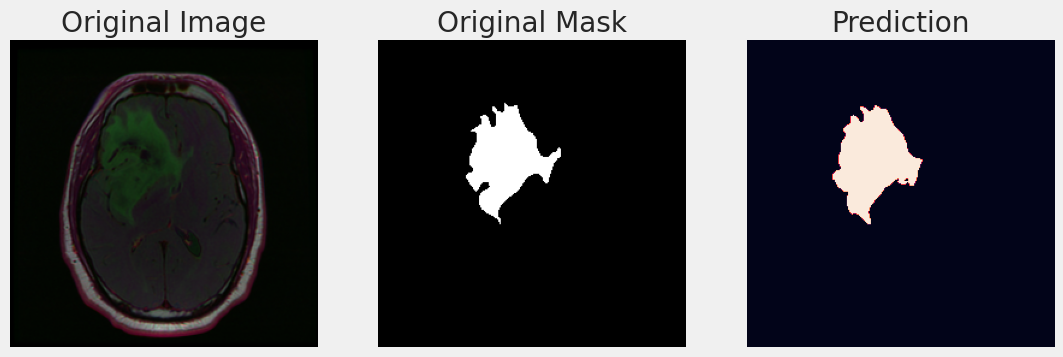

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


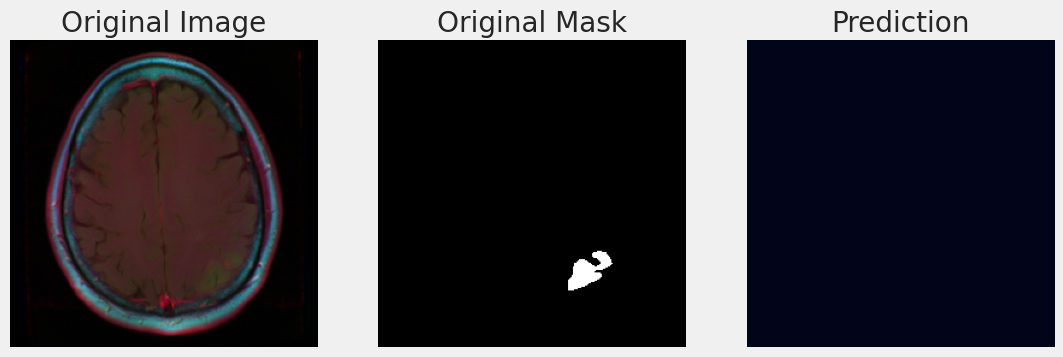

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


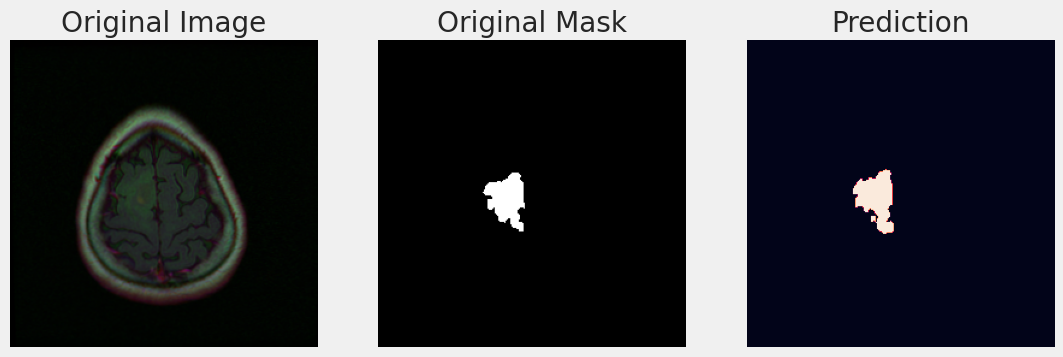

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


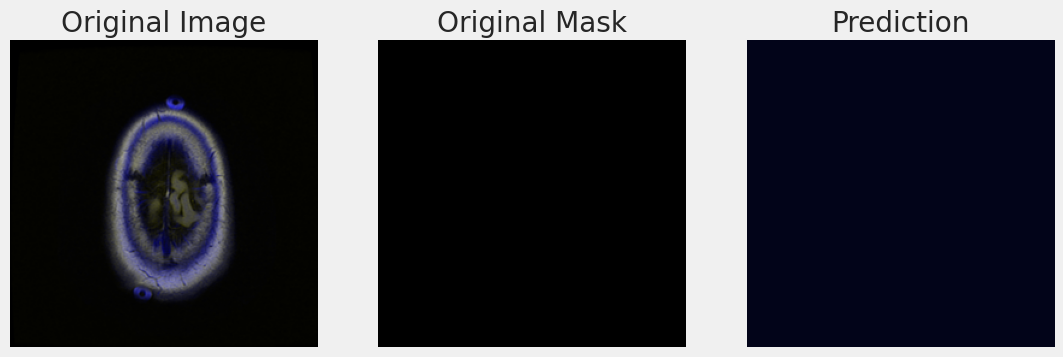

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


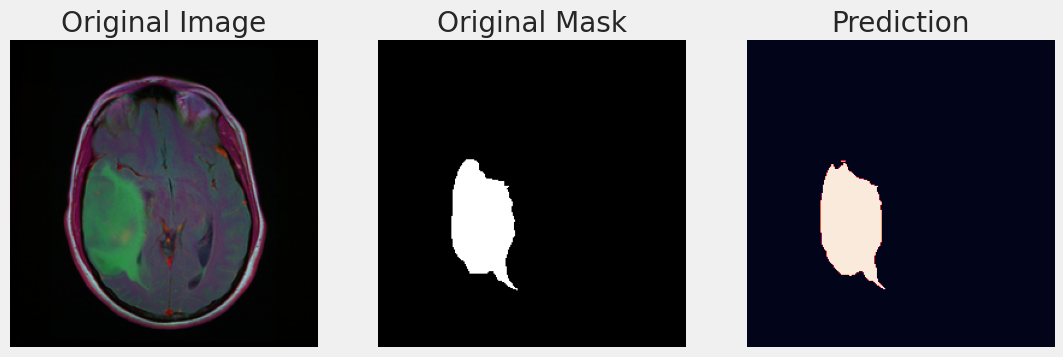

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


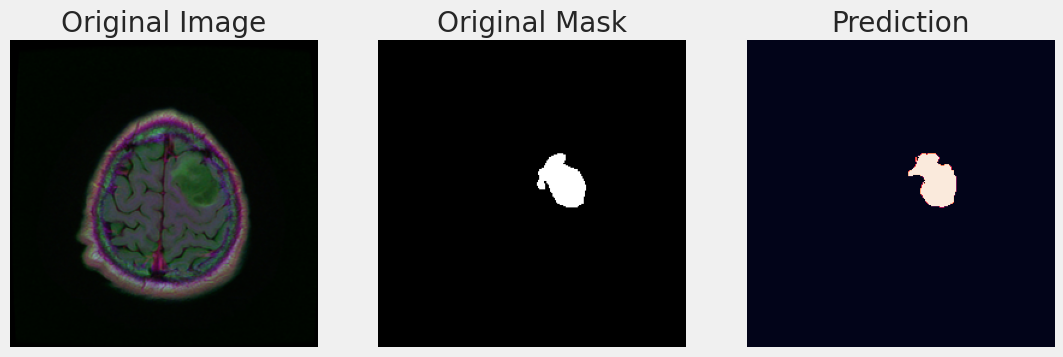

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


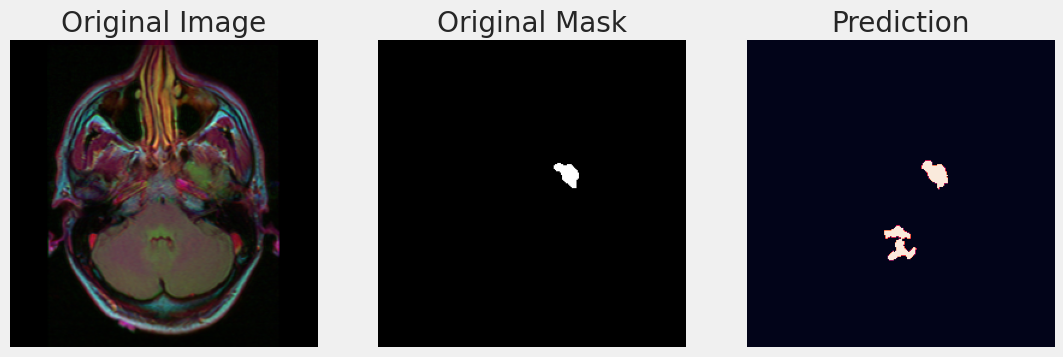

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


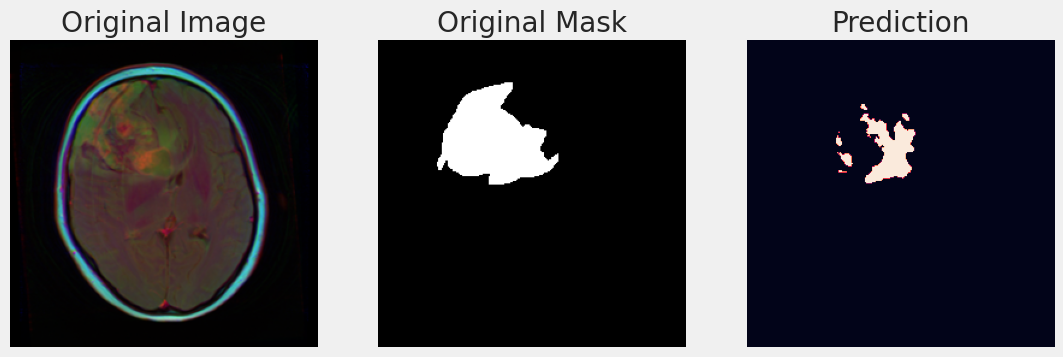

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


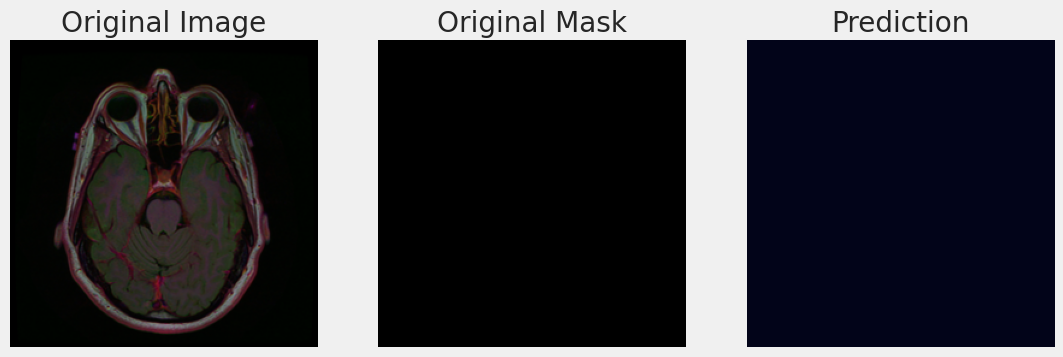

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


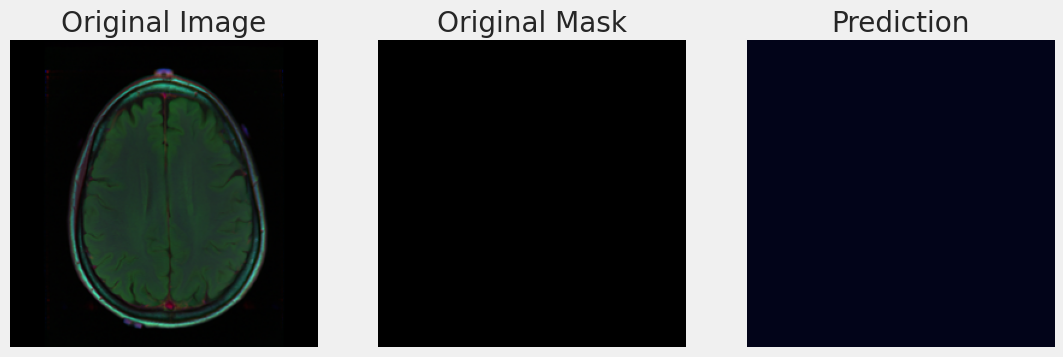

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


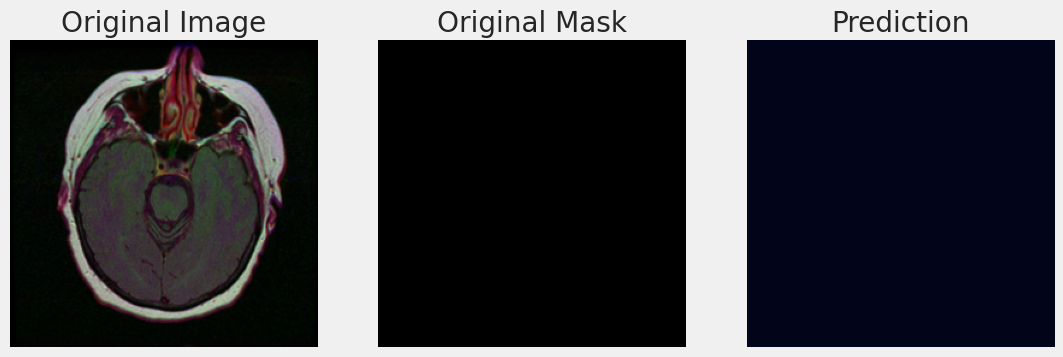

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


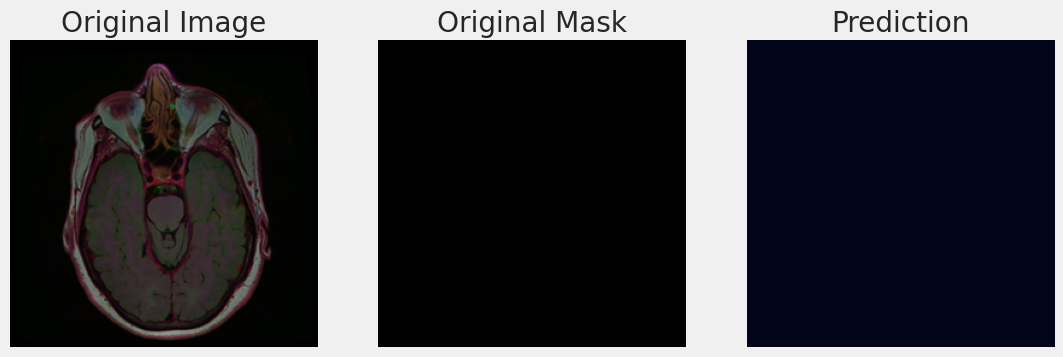

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


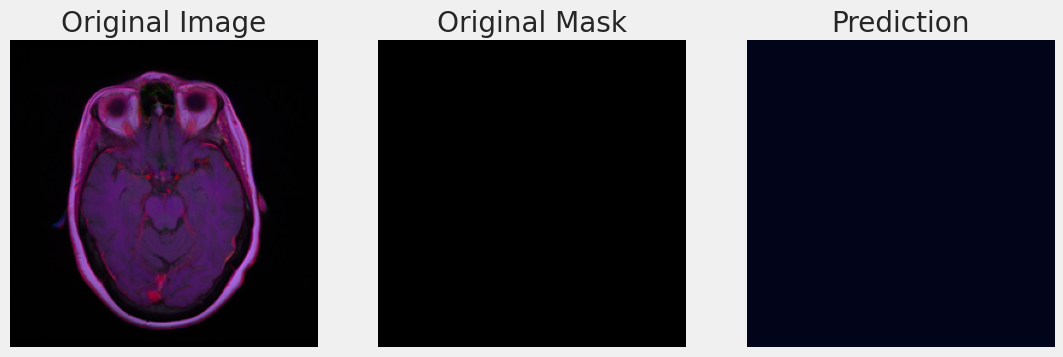

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


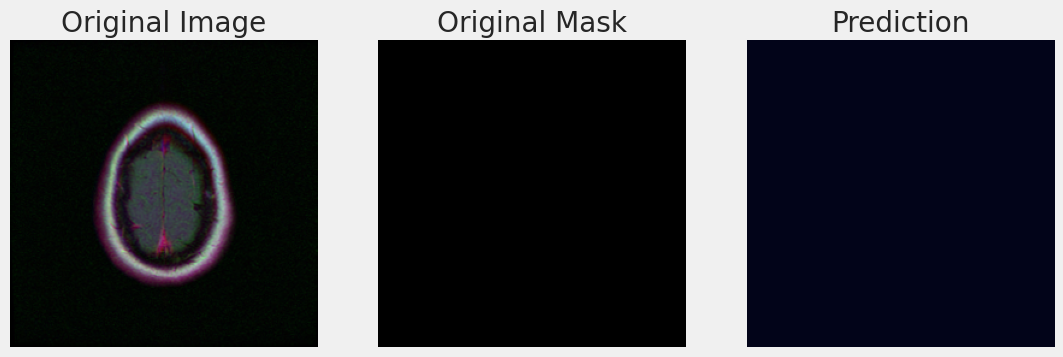

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


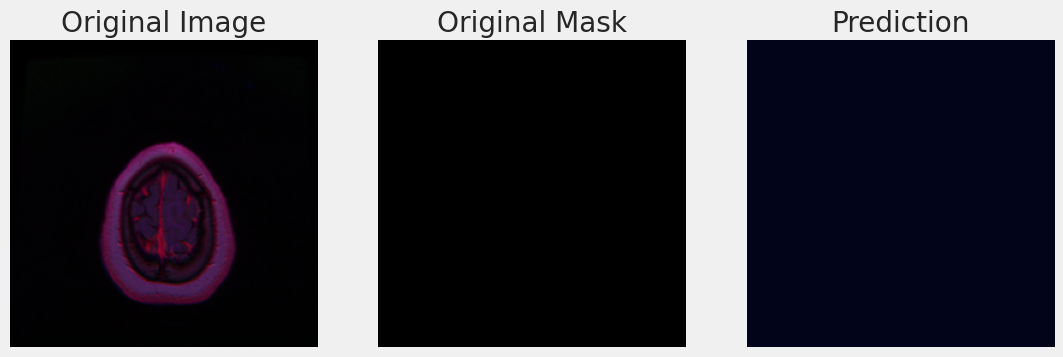

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


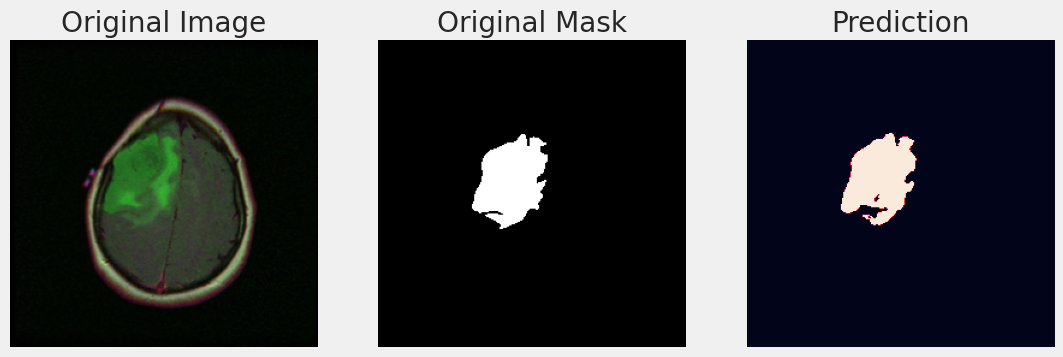

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


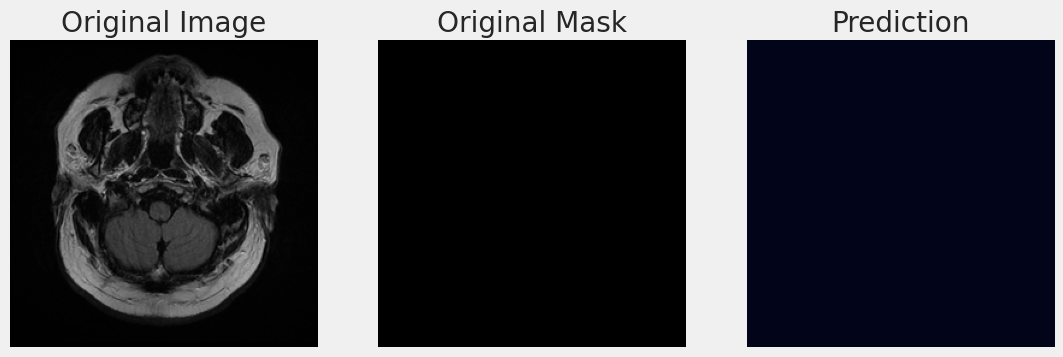

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


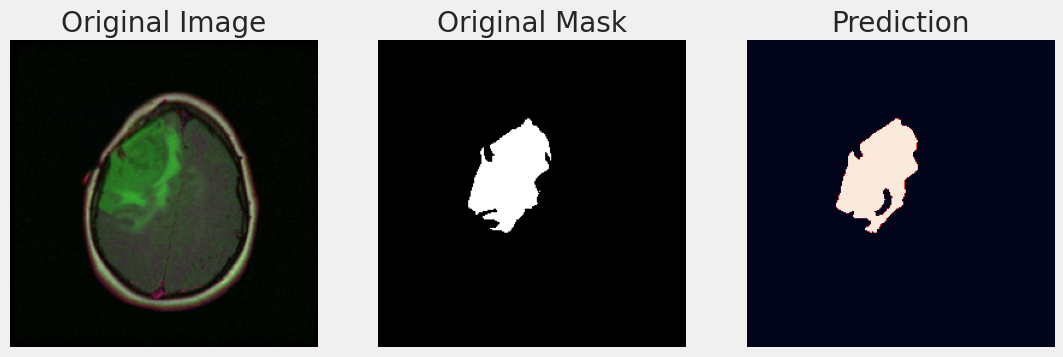

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


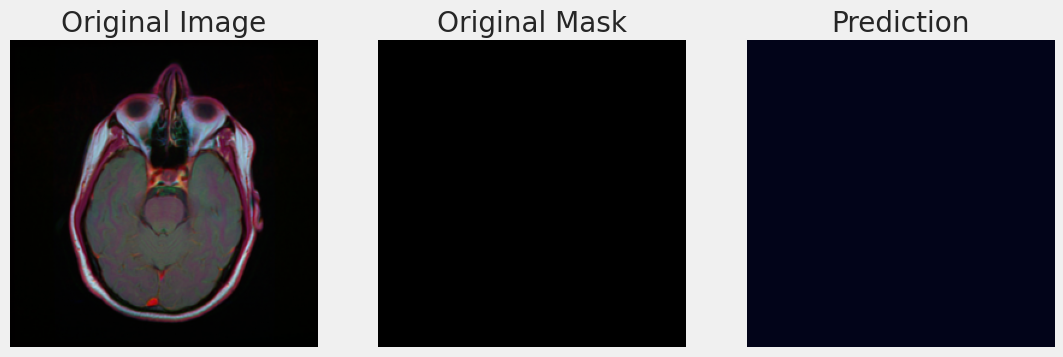

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


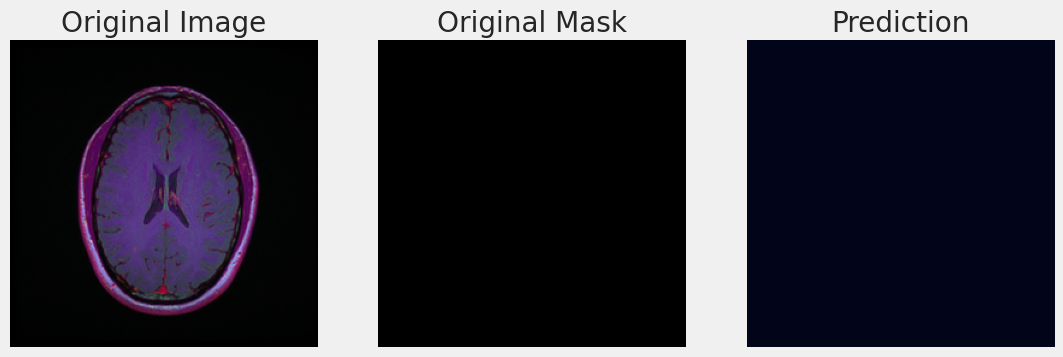

In [19]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()

In [ ]:
from IPython.display import FileLink

# Compress model files (if needed)
!zip -r unet_final.zip /kaggle/working/unet_models/unet_final.keras

# Create download link
FileLink('unet_final.zip')  # Click the generated link to download


  adding: kaggle/working/unet_models/unet_final.keras